# Amino Acid Quantitation

The following notebook describes the sample handling and analysis used to process collaborative samples provided by Hayley B on 01/19/21.

The samples contain glycine and alanine starting monomers as well as unknown amounts of peptides.

In [11]:
from commons.data_processing import *
from commons.my_mzml import *
from scipy.stats import linregress 
from scipy.signal import find_peaks, peak_widths
from altair.expr import datum
import os 
import re 
import ntpath 
import sys
import numpy as np 
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

In [12]:
data_dir = r'.\AA Quant'
aa_files = get_files(data_dir, exts=['.mzXML'])

In [13]:
std = [f for f in aa_files if re.search(r'Std', f)]
standards = {
    "0uM":[f for f in std if re.search('_0uM', f)],
    "10uM":[f for f in std if re.search('_10uM', f)],
    "25uM":[f for f in std if re.search('_25uM', f)],
    "50uM":[f for f in std if re.search('_50uM', f)],
    "100uM":[f for f in std if re.search('_100uM', f)],
    "150uM":[f for f in std if re.search('_150uM', f)],
    "200uM":[f for f in std if re.search('_200uM', f)],
}

rat_75 = [f for f in aa_files if re.search(r'_75_25', f)]
ratio_75 = {
    'day_1':[f for f in rat_75 if re.search(r'day1', f)],
    'day_2':[f for f in rat_75 if re.search(r'day2', f)],
    'day_3':[f for f in rat_75 if re.search(r'day3', f)],
    'day_4':[f for f in rat_75 if re.search(r'day4', f)],
}

rat_50 = [f for f in aa_files if re.search(r'_50_50', f)]
ratio_50 = {
    'day_1':[f for f in rat_50 if re.search(r'day1', f)],
    'day_2':[f for f in rat_50 if re.search(r'day2', f)],
    'day_3':[f for f in rat_50 if re.search(r'day3', f)],
    'day_4':[f for f in rat_50 if re.search(r'day4', f)],
}

rat_25 = [f for f in aa_files if re.search(r'_25_75', f)]
ratio_25 = {
    'day_1':[f for f in rat_25 if re.search(r'day1', f)],
    'day_2':[f for f in rat_25 if re.search(r'day2', f)],
    'day_3':[f for f in rat_25 if re.search(r'day3', f)],
    'day_4':[f for f in rat_25 if re.search(r'day4', f)],
}

In [14]:
# define functions used throughout

def confine_data(x, y, offset=0.05):
    '''
    Function to remove array components that are not
    part of m/z peak of interest.

    :param x: (np.array) array contain x values
    :param y: (np.array) array contain y values
    :param offset: (float) cutoff distance from peak maximum 
    '''
    err_str = 'x and y data must enter as type(np.ndarray)'
    assert isinstance(x, np.ndarray), err_str
    assert isinstance(y, np.ndarray), err_str

    peak = np.where(y==np.max(y))
    left, right = x[peak]-offset, x[peak]+offset
    _range = np.logical_and(x>left, x<right)
    return x[_range], y[_range]

def correct_baseline(x, y, num_points=10):
    '''
    Function to remove baseline from MS data.

    :param x: (np.array) array contain x values
    :param y: (np.array) array contain y values
    :param num_points: (int) number of points used to determine noise level 
    '''
    err_str = 'x and y data must enter as type(np.ndarray)'
    assert isinstance(x, np.ndarray), err_str
    assert isinstance(y, np.ndarray), err_str

    avg = np.mean(y[:num_points])
    return x, y-avg

def convert_string(s):
    '''Function to covert string value to integer value.'''
    s = s[:-2]
    return int(s)

## Pulling peaks to form calibration curve
#### Glycine

In order to create a calibration curve, we must pull out the MS1 level signal for both heavy and light isotoplogues of each amino acid.
Below we will search the .mzXML file for our masses of interest, plot them on a shared axis for each concentration, remove the data that is not part of the peak, and find its integral. These integrals will serve as the peak area for each run and be used to create a calibration curve.

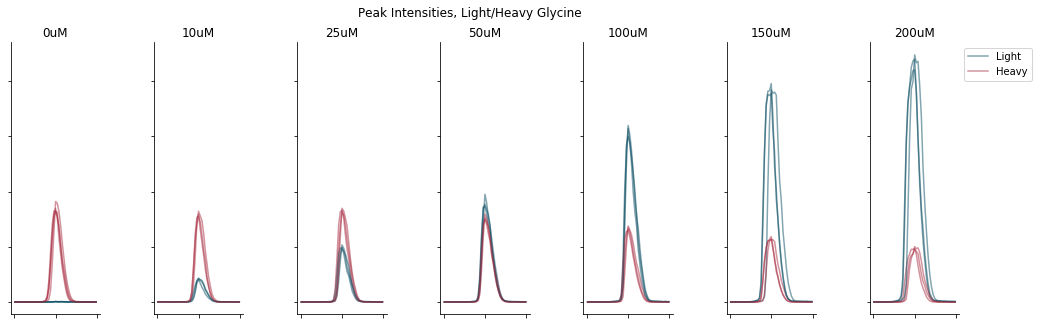

In [15]:
keys = list(standards.keys())

# define masses that will be searched
masses = [76.038, 77.035]
colors = ['#084C61', '#A6293E']

# instantiate dictionary to store data
gly = {
    'concentration':[],
    'run':[],
    'heavy':[],
    'light':[],
}

# prepare blank figure to plot data
fig, axs = plt.subplots(1, len(standards), figsize=(17, 5), sharey=True)
plt.subplots_adjust(wspace=0.6)

# iterate subplots and files to pull data
for i, ax in enumerate(axs.flat):
    files = standards[keys[i]]
    xs, ys = [], []
    offset = 0.05
    center = 1.5
    for j, file in enumerate(files):
        base = ntpath.basename(file)
        name, _ = ntpath.splitext(base)
        n = name.split('_')
        conc, run = n[-2], n[-1]
        gly['concentration'].append(conc)
        gly['run'].append(run)
        for mass in masses:
            m = mzXML(file)
            x, y = m.ms1_extract(mass)

            # correct the x array (time points) so all peaks 
            # will be centered on one another
            intensity_max = np.where(y == np.max(y))
            x = x + (center - x[intensity_max])
            # x, y = correct_baseline(x, y)
            x, y = confine_data(x, y, offset=offset)

            # find peaks
            peak, _ = find_peaks(y, np.max(y))
            _, height, left, right = peak_widths(y, peak, rel_height=1.0)
            integral = np.trapz(y[int(left):int(right)])

            if keys[i] == '0uM' and mass == masses[0]:
                gly['light'].append(0)
            elif mass == masses[0]:
                gly['light'].append(integral)
            else:
                gly['heavy'].append(integral)

            ax.plot(x, y, color=colors[masses.index(mass)], alpha=0.5)
            ax.set_title(conc)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    plt.legend(['Light', 'Heavy'], bbox_to_anchor=[1, 1])
    plt.suptitle('Peak Intensities, Light/Heavy Glycine')
    plt.savefig('Peak Intensities Control_Glycine.svg')

#### Alanine

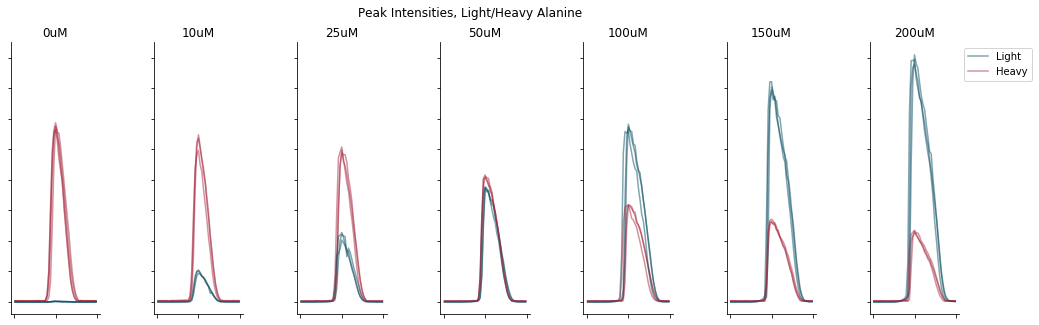

In [16]:
keys = list(standards.keys())

# define masses that will be searched
masses = [90.053, 91.051]
colors = ['#084C61', '#A6293E']

# instantiate dictionary to store data
ala = {
    'concentration':[],
    'run':[],
    'heavy':[],
    'light':[],
}

# prepare blank figure to plot data
fig, axs = plt.subplots(1, len(standards), figsize=(17, 5), sharey=True)
plt.subplots_adjust(wspace=0.6)

# iterate subplots and files to pull data
for i, ax in enumerate(axs.flat):
    files = standards[keys[i]]
    xs, ys = [], []
    offset = 0.05
    center = 1.5
    for j, file in enumerate(files):
        base = ntpath.basename(file)
        name, _ = ntpath.splitext(base)
        n = name.split('_')
        conc, run = n[-2], n[-1]
        ala['concentration'].append(conc)
        ala['run'].append(run)
        for mass in masses:
            m = mzXML(file)
            x, y = m.ms1_extract(mass)

            # correct the x array (time points) so all peaks 
            # will be centered on one another
            intensity_max = np.where(y == np.max(y))
            x = x + (center - x[intensity_max])
            # x, y = correct_baseline(x, y)
            x, y = confine_data(x, y, offset=offset)

            # find peaks
            peak, _ = find_peaks(y, np.max(y))
            _, height, left, right = peak_widths(y, peak, rel_height=1.0)
            integral = np.trapz(y[int(left):int(right)])

            if keys[i] == '0uM' and mass == masses[0]:
                ala['light'].append(0)
            elif mass == masses[0]:
                ala['light'].append(integral)
            else:
                ala['heavy'].append(integral)

            ax.plot(x, y, color=colors[masses.index(mass)], alpha=0.5)
            ax.set_title(conc)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    plt.legend(['Light', 'Heavy'], bbox_to_anchor=[1, 1])
    plt.suptitle('Peak Intensities, Light/Heavy Alanine')
    plt.savefig('Peak Intensities Control_Alanine.svg')

In [17]:
# create blank dataframe for when we store our data
df = pd.DataFrame()

# create dictionarie to store lin regress values
gly_reg, ala_reg = {}, {}
regs = [gly_reg, ala_reg]

acids = ['glycine', 'alanine']

for i, d in enumerate([gly, ala]):
    print(acid:=acids[i])
    d['amino_acid'] = [acid]*len(d['run'])
    
    sub = pd.DataFrame(d)
    sub.loc[:, 'ratio'] = sub.light/sub.heavy
    sub.loc[:, 'concentration'] = sub.concentration.map(convert_string)
    
    m, b, r, _, _ = linregress(sub.concentration, sub.ratio)
    s = regs[i]
    s['slope'] = m 
    s['intercept'] = b 
    s['fit'] = r
    print(f'y = {m}x + {b}')
    print(f'R\N{SUPERSCRIPT TWO} = {r}')
    lin_x = np.linspace(7.5, 192.5, len(d['run']))
    lin_y = m * lin_x + b

    sub['lin_x'] = lin_x
    sub['lin_y'] = lin_y
    if df.empty:
        df = sub
    else:
        df = pd.concat([df, sub])

df.head()

glycine
y = 0.022972434147940344x + 0.025759334954279955
R² = 0.9999085877250893
alanine
y = 0.01740304032839063x + 0.014170912287917892
R² = 0.9998178630456833


,concentration,run,heavy,light,amino_acid,ratio,lin_x,lin_y
0,0,run1,1.147140e+07,0.000000e+00,glycine,0.000000,7.500000,0.198053
1,0,run2,1.185746e+07,0.000000e+00,glycine,0.000000,16.309524,0.400429
2,0,run3,1.111995e+07,0.000000e+00,glycine,0.000000,25.119048,0.602805
3,0,run4,1.118801e+07,0.000000e+00,glycine,0.000000,33.928571,0.805181
4,10,run1,1.121508e+07,2.957601e+06,glycine,0.263716,42.738095,1.007557


In [18]:
cal_curve = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('concentration', title='Concentration Light Amino Acid (uM)'),
    y=alt.Y('mean(ratio)', title='Peak Area Ratio (Light/Heavy)')
).properties(width=1000)

lin_fit = alt.Chart(df).mark_line(color='black', strokeDash=[5, 5]).encode(
    x='lin_x', y='lin_y',
)

chart = alt.vconcat()

for acid in df.amino_acid.unique():
    scatter = cal_curve.transform_filter(datum.amino_acid==acid)
    line = lin_fit.transform_filter(datum.amino_acid==acid)
    chart &= (scatter + line).properties(title=f'Calibration Curve, {acid[0].upper() + acid[1:]}')

chart.save('CalibrationCurves.svg')

### Determining experimental concentrations in each experimental sample

Using the established method seen above, we will extract the MS1 level intensities for both the heavy and light isotopologues

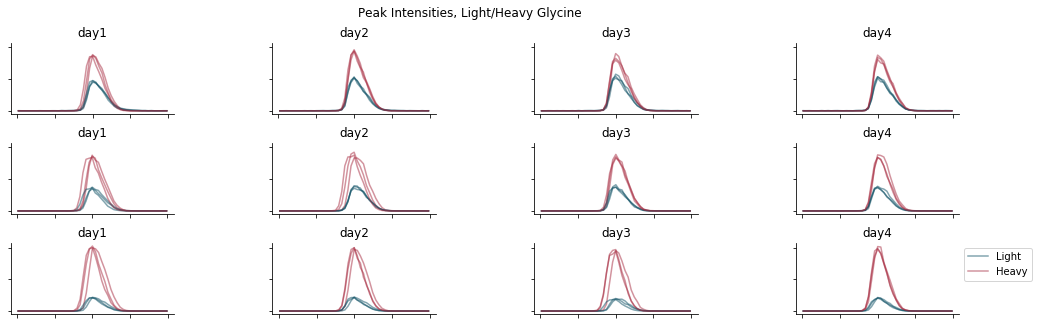

In [19]:
keys = list(ratio_75.keys()) + list(ratio_50.keys()) + list(ratio_25.keys())
dicts = [ratio_75, ratio_50, ratio_25]
# define masses that will be searched
masses = [76.038, 77.035]
colors = ['#084C61', '#A6293E']

# instantiate dictionary to store data
exp_gly = {
    'concentration':[],
    'day':[],
    'run':[],
    'heavy':[],
    'light':[],
}

# prepare blank figure to plot data
fig, axs = plt.subplots(3, len(keys) // 3, figsize=(17, 5), sharey=True)
plt.subplots_adjust(wspace=0.6, hspace=0.4)

# iterate subplots and files to pull data
for i, ax in enumerate(axs.flat):
    d = dicts[i // 4]
    files = d[keys[i]]
    xs, ys = [], []
    offset = 0.05
    center = 1.5
    for j, file in enumerate(files):
        base = ntpath.basename(file)
        name, _ = ntpath.splitext(base)
        n = name.split('_')
        conc, day, run = n[-3], n[-2], n[-1]
        exp_gly['concentration'].append(conc)
        exp_gly['day'].append(day)
        exp_gly['run'].append(run)
        for mass in masses:
            m = mzXML(file)
            x, y = m.ms1_extract(mass)

            # correct the x array (time points) so all peaks 
            # will be centered on one another
            intensity_max = np.where(y == np.max(y))
            x = x + (center - x[intensity_max])
            x, y = confine_data(x, y, offset=offset)

            # find peaks
            peak, _ = find_peaks(y, np.max(y))
            _, height, left, right = peak_widths(y, peak, rel_height=1.0)
            integral = np.trapz(y[int(left):int(right)])

            if keys[i] == '0uM' and mass == masses[0]:
                exp_gly['light'].append(0)
            elif mass == masses[0]:
                exp_gly['light'].append(integral)
            else:
                exp_gly['heavy'].append(integral)

            ax.plot(x, y, color=colors[masses.index(mass)], alpha=0.5)
            ax.set_title(day)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    plt.legend(['Light', 'Heavy'], bbox_to_anchor=[1, 1])
    plt.suptitle('Peak Intensities, Light/Heavy Glycine')
    plt.savefig('Peak Intensities Experimental_Glycine.svg')

20210123_GD_ZC_HS_MetBGE_800V_75_25_day1_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day1_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day1_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day2_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day2_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day2_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day3_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day3_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day3_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day4_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day4_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_75_25_day4_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day1_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day1_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day1_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day2_run1.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day2_run2.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day2_run3.mzXML
20210123_GD_ZC_HS_MetBGE_800V_50_50_day3_run1.mzXML
20210123_GD_

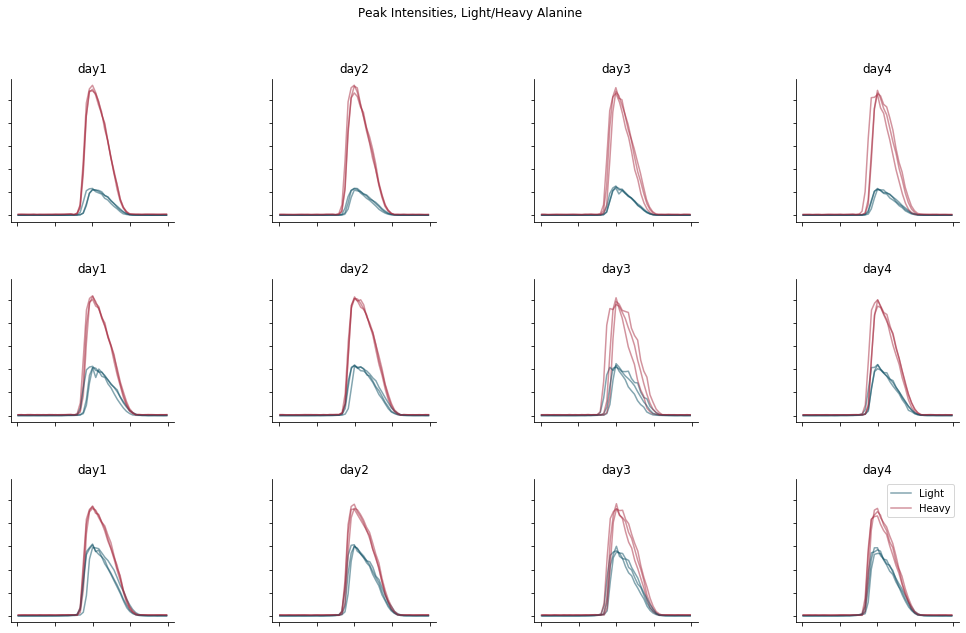

In [20]:
keys = list(ratio_75.keys()) + list(ratio_50.keys()) + list(ratio_25.keys())
dicts = [ratio_75, ratio_50, ratio_25]
# define masses that will be searched
masses = [90.053, 91.051]
colors = ['#084C61', '#A6293E']

# instantiate dictionary to store data
exp_ala = {
    'concentration':[],
    'day':[],
    'run':[],
    'heavy':[],
    'light':[],
}

# prepare blank figure to plot data
fig, axs = plt.subplots(3, len(keys) // 3, figsize=(17, 10), sharey=True)
plt.subplots_adjust(wspace=0.6, hspace=0.4)

# iterate subplots and files to pull data
for i, ax in enumerate(axs.flat):
    d = dicts[i // 4]
    files = d[keys[i]]
    xs, ys = [], []
    offset = 0.05
    center = 1.5
    for j, file in enumerate(files):
        base = ntpath.basename(file)
        name, _ = ntpath.splitext(base)
        n = name.split('_')
        conc, day, run = n[-3], n[-2], n[-1]
        exp_ala['concentration'].append(conc)
        exp_ala['day'].append(day)
        exp_ala['run'].append(run)
        for mass in masses:
            m = mzXML(file)
            x, y = m.ms1_extract(mass)

            # correct the x array (time points) so all peaks 
            # will be centered on one another
            intensity_max = np.where(y == np.max(y))
            x = x + (center - x[intensity_max])
            x, y = confine_data(x, y, offset=offset)

            # find peaks
            peak, _ = find_peaks(y, np.max(y))
            _, height, left, right = peak_widths(y, peak, rel_height=1.0)
            integral = np.trapz(y[int(left):int(right)])

            if keys[i] == '0uM' and mass == masses[0]:
                exp_ala['light'].append(0)
            elif mass == masses[0]:
                exp_ala['light'].append(integral)
            else:
                exp_ala['heavy'].append(integral)

            ax.plot(x, y, color=colors[masses.index(mass)], alpha=0.5)
            ax.set_title(day)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    plt.legend(['Light', 'Heavy'], bbox_to_anchor=[1, 1])
    plt.suptitle('Peak Intensities, Light/Heavy Alanine')
    plt.savefig('Peak Intensities Experimental_Alanine.svg')

In [25]:
gly_res = pd.DataFrame(exp_ala)
gly_res.loc[:, 'ratio'] = gly_res.light/gly_res.heavy

gly_res.loc[:, 'concentration (uM)'] = (gly_res.ratio - gly_reg['intercept']) / gly_reg['slope']
gly_res.loc[:, 'corrected concentration (M)'] = gly_res['concentration (uM)'] * 2000 / 1e6
avg_gly = gly_res.groupby(['concentration', 'day']).mean()
avg_gly.head()

heavy         light     ratio  concentration (uM)  \
concentration day                                                              
25            day1  4.667487e+07  9.609221e+06  0.205865            7.840074   
              day2  4.597998e+07  9.349145e+06  0.203368            7.731365   
              day3  4.388644e+07  9.906518e+06  0.225648            8.701253   
              day4  4.424314e+07  9.420298e+06  0.212903            8.146457   
50            day1  4.760953e+07  1.955741e+07  0.410673           16.755469   

                    corrected concentration (M)  
concentration day                                
25            day1                     0.015680  
              day2                     0.015463  
              day3                     0.017403  
              day4                     0.016293  
50            day1                     0.033511

In [24]:
ala_res = pd.DataFrame(exp_ala)
ala_res.loc[:, 'ratio'] = ala_res.light/ala_res.heavy

ala_res.loc[:, 'concentration (uM)'] = (ala_res.ratio - ala_reg['intercept']) / ala_reg['slope']
ala_res.loc[:, 'corrected concentration (M)'] = ala_res['concentration (uM)'] * 2000 / 1e6
avg_ala = ala_res.groupby(['concentration', 'day']).mean()
avg_ala.head()

heavy         light     ratio  concentration (uM)  \
concentration day                                                              
25            day1  4.667487e+07  9.609221e+06  0.205865           11.014973   
              day2  4.597998e+07  9.349145e+06  0.203368           10.871474   
              day3  4.388644e+07  9.906518e+06  0.225648           12.151750   
              day4  4.424314e+07  9.420298e+06  0.212903           11.419405   
50            day1  4.760953e+07  1.955741e+07  0.410673           22.783510   

                    corrected concentration (M)  
concentration day                                
25            day1                     0.022030  
              day2                     0.021743  
              day3                     0.024303  
              day4                     0.022839  
50            day1                     0.045567

In [30]:
std_curve = df[['amino_acid', 'concentration', 'run', 'heavy', 'light', 'ratio']]
std_curve_grouped = std_curve.groupby(['amino_acid', 'concentration']).mean()
with pd.ExcelWriter('20210124_AG_Analysis.xlsx') as writer:
    std_curve.to_excel(writer, sheet_name='Standard Curve', index=False)
    std_curve_grouped.to_excel(writer, sheet_name='Standard Curve (Grouped)')
    gly_res.to_excel(writer, sheet_name='Glyine, All Data', index=False)
    avg_gly.to_excel(writer, sheet_name='Glyine, Grouped')
    ala_res.to_excel(writer, sheet_name='Alanine, All Data', index=False)
    avg_ala.to_excel(writer, sheet_name='Alanine, Grouped')